# Industrial Applications of Artificial Intelligence - Predicting Salary and possible Bias

### This notebook is part of the third hand-in regarding the tertiary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Credit decisions, personal potential evaluation or support in judgements. Machine Learning algorithms are touching more and more areas of people's personal lives. However, this is not always benefitial. A sensation has been caused in 2016 by the publication of ProPublica about the software COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) that should help in discovering the underlying risk of a criminal becoming a recidivist [[1]](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). The authors found out that the algorithm is highly biased towards black people such that "black defendants are far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism" [[2]](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). This impressively illustrates that if developers and designers are not careful, human bias is picked up by algorithms leading to highly unfair results. Therefore, one has to be especially cautious involving personal sensitive data, for example sex, political attitude or religious affiliation. In the following notebook, we explore the influence of sensitive information in the case of income prediction and investigate how sensitive data can influence the decision.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.feature_selection import f_classif, RFECV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

## I. Data Exploration

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset).  It was published by the Center for Machine Learning and Intelligent Systems of the University of California and the original dataset can be found under the following [link](http://www.cs.toronto.edu/~delve/data/adult/desc.html). The task is modelled as a binary classification to predict if an individual's income excceds $50,000 based on data from the US Census Bureau. We want to explore if sensitive information does have an influence on the result and compare it to the case, when some features are discarded.
First of all, the dataset consists out of 48,842 entries containing 14 features and one target, which will be described in the following. We are not given a test set such that we have to create a split in the course of the work.
* age: Integer indicating the age of a person.
* workclass: Categorical variable indicating the employment status of a person.
* fnlwgt: Integer without further description. Nearly unique value per row, so might be kind of an identifier that may need to be discarded.
* education: Categorical variable indicating the highest degree of a person. 
* educational-num: Integer indicating the number of years spent on education.
* marital-status: Categorical variable indicating the marriage status.
* occupation: Categorical variable that indicates the employment type that a person has. 
* relationship: Categorical variable indicating the relationship status.
* race: Categorical variable indicating the origin of a person.
* gender: Binary variable that indicates wether a person is male or female.
* capital-gain: Integer indicating if a person has capital gains.
* capital-loss: Integer indicating if a person has capital losses.
* hours-per-week: Integer indicating how much hours a person works per week
* native-country: Categorical variable indicating the native-country of a person.
* income: Target. Binary variable that indicates wether a person has more than 50k income or not.

In [3]:
dir_path ='../../src/data/Abgabe_3/'

In [4]:
df = pd.read_csv(os.path.join(dir_path, "adult.csv"))
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [5]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,48842.00,38.64,13.71,17.00,28.00,37.00,48.00,90.00
fnlwgt,48842.00,189664.13,105604.03,12285.00,117550.50,178144.50,237642.00,1490400.00
educational-num,48842.00,10.08,2.57,1.00,9.00,10.00,12.00,16.00
capital-gain,48842.00,1079.07,7452.02,0.00,0.00,0.00,0.00,99999.00
capital-loss,48842.00,87.50,403.00,0.00,0.00,0.00,0.00,4356.00
hours-per-week,48842.00,40.42,12.39,1.00,40.00,40.00,45.00,99.00


We can clearly see that we have two highly critical features inside our data: race and gender. On top of that, the native-country could have an influence as well. If an algorithm would be totally objective, neither of these variables should have big influence on the result. That means the distribution of income should not differ wether a person is male or female or he/she belongs to a different race. As a first step, we explore the distribution of those variables and investigate if there are already obvious conspicuities.

In [6]:
df.groupby('gender').income.value_counts()

gender  income
Female  <=50K     14423
        >50K       1769
Male    <=50K     22732
        >50K       9918
Name: income, dtype: int64

In [7]:
df.groupby('race').income.value_counts()

race                income
Amer-Indian-Eskimo  <=50K       415
                    >50K         55
Asian-Pac-Islander  <=50K      1110
                    >50K        409
Black               <=50K      4119
                    >50K        566
Other               <=50K       356
                    >50K         50
White               <=50K     31155
                    >50K      10607
Name: income, dtype: int64

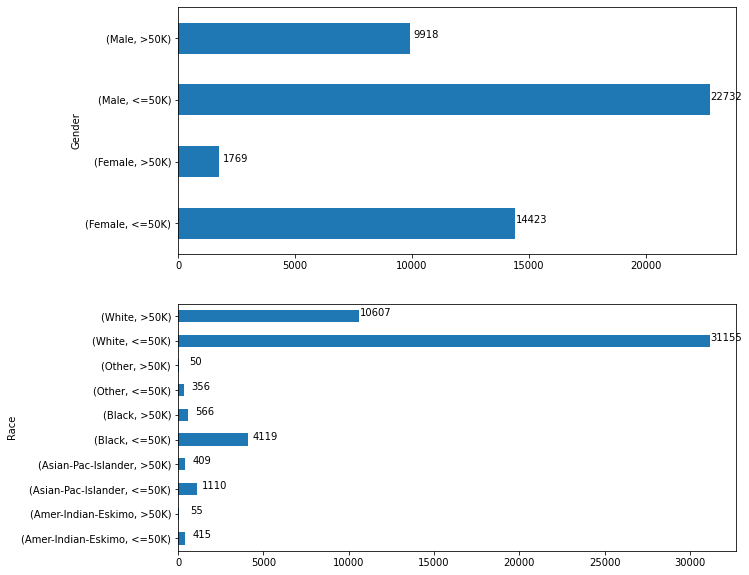

In [8]:
fig, (ax, ax2) = plt.subplots(2, 1,  figsize=(10,10))

df.groupby('gender').income.value_counts().plot(kind='barh',ax=ax)
ax.set_ylabel('Gender')
[ax.text(v+700, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('gender').income.value_counts())]
df.groupby('race').income.value_counts().plot(kind='barh',ax=ax2)
ax2.set_ylabel('Race')
[ax2.text(v+1000, i, '{:}'.format(v), horizontalalignment='center') for i, v in enumerate(df.groupby('race').income.value_counts())]
plt.show()

We can see that there is already a difference in the distribution towards women having less income than men. In the case of the race feature, it is also obvious that the distributions differ a lot with white people having higher income overall, which looks a lot like bias. The question remains if this is picked up by an algorithm in a way that it is more likely to predict whites having overall higher income.

We gonna investigate right now, if the distributions of the numerical variables differ a lot for gender. For this reason, we split the dataset based on the feature and have a look at the other variables.

In [9]:
# Male
df_male = df[df['gender'] == 'Male']
#Female
df_female = df[df['gender'] == 'Female']

In [10]:
# look at distribution
df_male.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,32650.00,39.49,13.41,17.00,29.00,38.00,48.00,90.00
fnlwgt,32650.00,191727.02,106709.38,13492.00,117963.00,180138.00,241722.50,1490400.00
educational-num,32650.00,10.09,2.66,1.00,9.00,10.00,13.00,16.00
capital-gain,32650.00,1326.21,8367.78,0.00,0.00,0.00,0.00,99999.00
capital-loss,32650.00,100.41,430.22,0.00,0.00,0.00,0.00,3770.00
hours-per-week,32650.00,42.42,12.12,1.00,40.00,40.00,48.00,99.00


In [11]:
# look at distribution
df_female.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,16192.00,36.93,14.14,17.00,25.00,35.00,46.00,90.00
fnlwgt,16192.00,185504.47,103217.15,12285.00,116560.00,175572.00,228609.25,1484705.00
educational-num,16192.00,10.04,2.38,1.00,9.00,10.00,12.00,16.00
capital-gain,16192.00,580.73,5094.23,0.00,0.00,0.00,0.00,99999.00
capital-loss,16192.00,61.48,340.11,0.00,0.00,0.00,0.00,4356.00
hours-per-week,16192.00,36.40,11.95,1.00,30.00,40.00,40.00,99.00


We see that in most cases the statistical properties of the features do not differ by a lot. However, there are two features that stand out: age and hours-per-week. It seems that women in the dataset are overal younger and work less. This might be a possible explanation. In contrast, years of education are higher, which should actually indicate that women earn more.

Before we preprocess the dataset and execute predictions, we examine some of the feature distributions to get more insights into the data. 

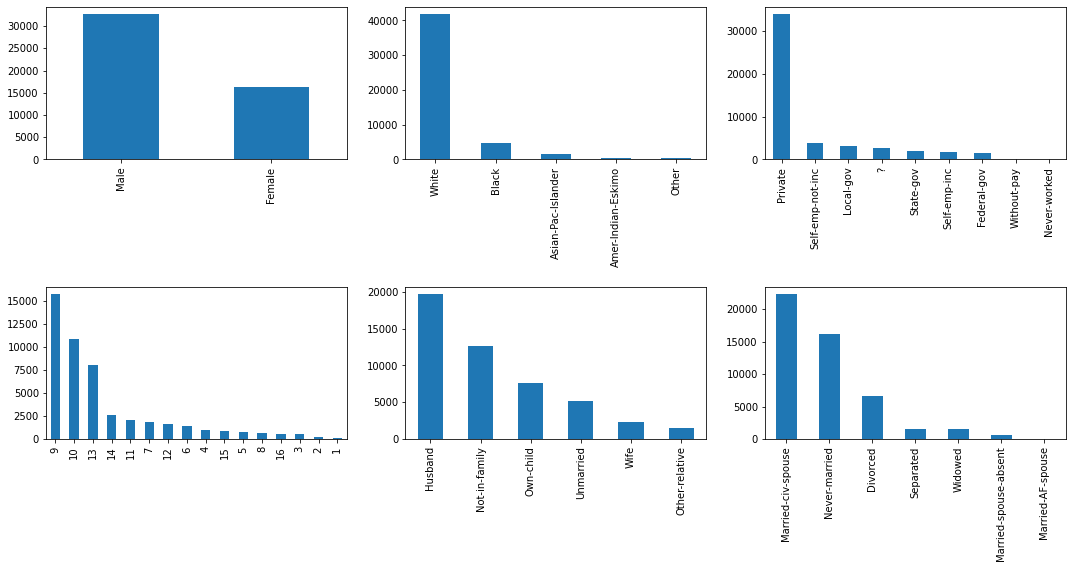

In [12]:
fig, axes = plt.subplots(2, 3,  figsize=(15,8))

#list of features to show
features = ['gender','race','workclass','educational-num','relationship','marital-status']

for i in range(2):
    for j in range(3):
        df[features[3*i+j]].value_counts().plot(kind='bar', ax = axes[i,j])
fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

We can already see that we have a lot more male than female persons within the dataset and that the race distribution is clearly skewed in favor of whites, which could be problematic in the remaining analysis. On top of that, it is also noticeable that the majority of people in the study work in the private sector.
Most of people have 9 years of school education, which is equivalent to a high school graduation. Furthermore, it is evident that we have far more people pursuing higher education than stopping before nine years. Regarding relationship and marital-status, it seems that most people are either married or have never-married. We also see that relationship and marital-status might be somehow redundant, because there is a clear overlap. Therefore, we investigate the correlations between all the features in the course of the work.

We have already seen that the educational level and hours-per-week differ between male and females. We want to further investigate the relations and compare them to each other for sex and race. We normalize the values for better comparison, because the distribution is skewed.

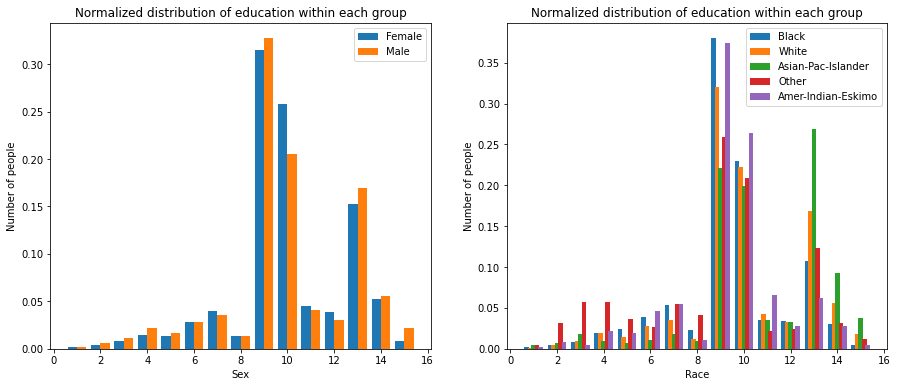

In [13]:
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,6))

#plot for gender
X_axis = np.arange(len(df['educational-num'].unique()))
  
ax.bar(X_axis - 0.2, df[df['gender']=='Female'].groupby('gender')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['gender']=='Female']), 0.4, label = 'Female')
ax.bar(X_axis + 0.2, df[df['gender']=='Male'].groupby('gender')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['gender']=='Male']), 0.4, label = 'Male')
  
ax.set_xlabel("Sex")
ax.set_ylabel("Number of people")
ax.set_title("Normalized distribution of education within each group")
ax.legend()


#plot for race
X_axis = np.arange(len(df['educational-num'].unique()))
  
ax2.bar(X_axis - 0.3, df[df['race']=='Black'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Black']), 0.2, label = 'Black')
ax2.bar(X_axis - 0.15, df[df['race']=='White'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='White']), 0.2, label = 'White')
ax2.bar(X_axis , df[df['race']=='Asian-Pac-Islander'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Asian-Pac-Islander']), 0.2, label = 'Asian-Pac-Islander')
ax2.bar(X_axis + 0.15, df[df['race']=='Other'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Other']), 0.2, label = 'Other')
ax2.bar(X_axis + 0.3, df[df['race']=='Amer-Indian-Eskimo'].groupby('race')['educational-num'].value_counts().sort_index().shift(1)/len(df[df['race']=='Amer-Indian-Eskimo']), 0.2, label = 'Amer-Indian-Eskimo')
  
ax2.set_xlabel("Race")
ax2.set_ylabel("Number of people")
ax2.set_title("Normalized distribution of education within each group")
ax2.legend()

plt.show()

We can see that there is a small tendency for women to have a higher percentage share completing higher education (e.g., a college: 10-12 years). However, the tendency shifts again, when it comes to doctoral degress (>12 years), where the share of man is higher again in percentage.
Based on the race there is a clear tendency that Asian-American pursue higher degrees, even doctoral dignities. For the other groups it seems that the main percentage of people having nine years of education, with some exceptions, e.g., Whites having a clear edge in percentage in >=13 years of education over the other groups outside Asian-American. Based on the educational-data, we can see that there might be problematic cases of having different distributions, especially for the races. In contrast, we have already seen that women earn less than men, which cannot be based on the number of years of training.

In the following, we investigate how good an algorithm is able to predict the income and if the distributions may further change due to bias.

# II. Preprocessing

Before we start with our preprocessing, we investigate the feature fnlwgt, because we noticed that it seems to be pretty unique and could therefore be redundant.

In [14]:
len(df)

48842

In [15]:
df.fnlwgt.nunique()

28523

In [16]:
df[df.fnlwgt==151910]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
44479,23,Private,151910,Bachelors,13,Never-married,Machine-op-inspct,Own-child,White,Female,0,1719,40,United-States,<=50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see that more than half of the entries have unique labels in the fnlwgt feature and if two entries have the same, they do not seem to be related. It is for this reason that we discard the feature as it does not offer any generalization improvement. 

In [17]:
df.drop(columns=['fnlwgt'],inplace =True)

In [18]:
df.head(5)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Before we use an algorithm on the data, we gonna preprocess the features for better usage. In a first step, we check the set for missing values.

In [19]:
df.isna().sum()

age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

We can see that in the whole set are no missing values. But is seems like in the dataset missing values are encoded as '?', because the publishers of the dataset state that there are around 7% missing values in the data. 

In [20]:
df[df.eq("?").any(1)]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
6,29,?,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
13,58,?,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
19,40,Private,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,?,>50K
22,72,?,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,?,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
48812,30,?,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
48820,71,?,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
48822,41,?,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [21]:
for col in df.columns:
    print(f'Feature {col} has {len(df[df[col]=="?"])} missing values')

Feature age has 0 missing values
Feature workclass has 2799 missing values
Feature education has 0 missing values
Feature educational-num has 0 missing values
Feature marital-status has 0 missing values
Feature occupation has 2809 missing values
Feature relationship has 0 missing values
Feature race has 0 missing values
Feature gender has 0 missing values
Feature capital-gain has 0 missing values
Feature capital-loss has 0 missing values
Feature hours-per-week has 0 missing values
Feature native-country has 857 missing values
Feature income has 0 missing values


The dataset contains 3,620 out of 48,842 rows (7.4%) with a least one question mark. We see that only workclass, occupation and native-country have missing values. We also know that workclass and occupation have a clear overlap and if someone does not offer his occupation than we do not get the workclass. First, we have a look at the correlations and see if we can fill features up based on other features. For this reason, we one-hot-encode the categorical features with the exception of the target.

In [22]:
df_ohe = pd.get_dummies(df, columns=["workclass", "education","marital-status","occupation","relationship","race","native-country","gender"])

In [23]:
corrMatrix=df_ohe.corr()
df_corr = corrMatrix[['workclass_?', 'occupation_?','native-country_?']]

In [24]:
df_corr[(abs(df_corr['workclass_?'])>=0.5) | (abs(df_corr['occupation_?'])>=0.5)|(abs(df_corr['native-country_?'])>=0.5)]

,workclass_?,occupation_?,native-country_?
workclass_?,1.000000,0.998110,-0.002088
occupation_?,0.998110,1.000000,-0.002202
native-country_?,-0.002088,-0.002202,1.000000


It seems that the correlations do not offer a lot of value to us, outside the occupation-workclass relationship. However, in most cases both values are missing. Therefore, we will update those values where one is given and the other one not. Since every imputation is not really better than guessing at the moment, we do not fill up the question marks yet and keep them, because they could provide usefull information. In our further work, we might investigate if discarding them completely or imputation, e.g., by median, offers better results.

In [25]:
df[((df['workclass']=='?')&(df['occupation']!='?'))|((df['workclass']!='?')&(df['occupation']=='?'))]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,?,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,?,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


We see that in all cases, where an occupation is missing that person has never worked before, which explaines the question mark. We have a short look on other cases with workclass equals never-worked and see if imputing those values would make sense.

In [26]:
df[df['workclass']=='Never-worked']

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,?,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,?,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


It seems, that there are no further cases and the question mark actually delivers information. Since there are more question marks in the occupation column, we will distinguish the never-workers by imputing no occupation instead of the question mark.

In [27]:
df.loc[(df['workclass']=='Never-worked'), 'occupation'] = 'No occupation'

In [28]:
df[df['workclass']=='Never-worked']

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,11th,7,Never-married,No occupation,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,HS-grad,9,Married-spouse-absent,No occupation,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,11th,7,Never-married,No occupation,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,10th,6,Never-married,No occupation,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,7th-8th,4,Divorced,No occupation,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,10th,6,Never-married,No occupation,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,11th,7,Never-married,No occupation,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,Some-college,10,Never-married,No occupation,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,HS-grad,9,Married-civ-spouse,No occupation,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,Some-college,10,Never-married,No occupation,Own-child,White,Male,0,0,4,United-States,<=50K


Furthermore, we encode all the categorical variables. The binary target variable and the binary variable for gender are encoded with 1 and 0, while the remaining categorical variables are one-hot-encoded.

In [29]:
cleanup_nums = {"gender": {'Female': 1, 'Male': 0},
                "income": {'>50K': 1, '<=50K': 0}}
df_preprocessed = df.replace(cleanup_nums)
df_preprocessed.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,0,40,United-States,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,0,50,United-States,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,0,40,United-States,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,7688,0,40,United-States,1
4,18,?,Some-college,10,Never-married,?,Own-child,White,1,0,0,30,United-States,0


In [30]:
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["workclass", "education","marital-status","occupation","relationship","race","native-country"])

In [31]:
df_preprocessed.head()

,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,10,0,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,1,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


To not always copy and paste those steps in further processing, we will define a function for the small preprocessing steps.

In [32]:
def preprocessing(df:pd.DataFrame, cleanup_nums: dict, categ:list) -> pd.DataFrame:
    """
    Function preprocess the dataset
    :param df: general dataframe
    :param cleanup_nums: dictionary of binary categorical columns to encode
    :param categ: list of categorical columns to one-hot-encode
    :return: preprocessed dataframe
    """

    df = df.replace(cleanup_nums)
    
    df = pd.get_dummies(df, columns=categ)
    # To avoid later processing problems, we rename the feature "educational_num" into "training_num"
    df.rename(columns = {'educational-num':'training-num'}, inplace = True )

    return df

In [33]:
df_preprocessed = preprocessing(df,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","race","native-country"])

In [34]:
df_preprocessed

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44,10,0,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,1,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,1,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,40,9,0,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,58,9,1,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,22,9,0,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Since we are not given a test set, we create a train-validation-test split to check the hypothesis in a next step.

# III. Train-Validation-Test-Split

Therefore, we split our given data into 60% train, 20% val and 20% test. Before we do that, we will have a short look on the distribution of our target to check for an imbalanced set.

<AxesSubplot:>

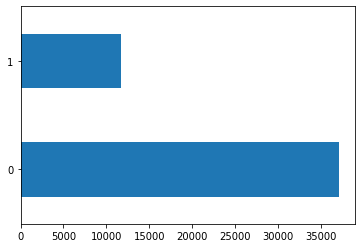

In [35]:
df_preprocessed['income'].value_counts().plot(kind ='barh')

We can clearly see that we have an imbalanced dataset with the majority of people earning less than 50k and therefore need to make sure to include this distribution in our splitted sets via stratified sampling. The imbalance is also an indicator for the usage of the f1-score as metric for our further downstream task instead of focusing only on accuracy, as accuracy would also deliver a good result if we have good results in the major class. We also keep the test set completely out of all steps except the last prediction to see how the algorithms performs on the test set as a generalization indicator.

In [37]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

In [38]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

We will now have a look at the values in our different sets to check wether the distribution of the target is nearly the same.

In [39]:
# define values for plots
x = ['>50k','<=50k']
y_train = target_train.value_counts().to_list()
y_val = target_val.value_counts().to_list()
y_test = target_test.value_counts().to_list()

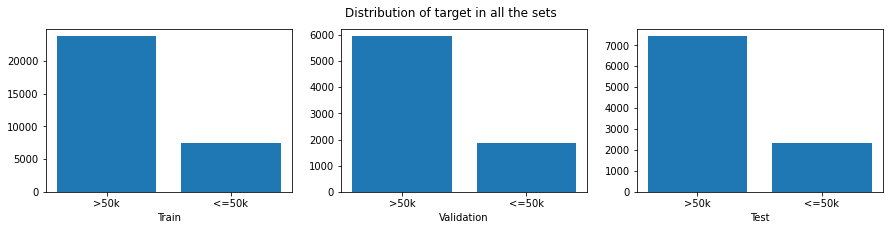

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(15,3))
fig.suptitle('Distribution of target in all the sets')
ax1.bar(x, y_train)
ax1.set_xlabel('Train')
ax2.bar(x, y_val)
ax2.set_xlabel('Validation')
ax3.bar(x, y_test)
ax3.set_xlabel('Test')
plt.show()

We can clearly see that the distribution is nearly the same for all our sets. As we generated the train-test-validation split in the previous step, we now want to scale the data. This is for the reason, that different scales might actually distort our algorithm a lot due to big differences in the scales. For scaling, we use the StandardScaler from the sklearn package. It should be noted that we only fit the scaler on our training data and use only the transformation on the validation and testing part, because we do not want to include information about validation and test that could already help the algorithm (data leakage).

In [41]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [42]:
data_train.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
32707,1.260788,-1.196134,0,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34860,-0.049988,1.132320,1,-0.144436,-0.219322,-0.445174,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32860,-1.506406,-0.808058,1,-0.144436,-0.219322,-1.653073,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
39091,-0.996659,-0.419983,0,-0.144436,-0.219322,2.373257,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17608,0.969505,-0.419983,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
data_val.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
2190,-0.414092,-0.031907,0,-0.144436,-0.219322,1.567991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37436,-0.195630,0.744244,0,-0.144436,3.879509,0.360092,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18121,-1.142301,-0.031907,0,-0.144436,-0.219322,0.279566,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5554,-0.705376,-0.031907,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14601,-1.069480,1.132320,0,-0.144436,-0.219322,-1.653073,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
data_test.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
40342,1.115147,-0.419983,1,-0.144436,-0.219322,-0.042541,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
47680,-0.778197,-0.419983,0,-0.144436,-0.219322,-1.653073,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
524,1.042326,-0.031907,0,-0.144436,-0.219322,0.762725,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8508,1.406430,-0.419983,0,0.287581,-0.219322,-1.975179,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31692,0.605400,0.744244,0,-0.144436,-0.219322,-0.042541,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# IV. First algorithm and possible bias

We use a classic decision tree classifier for the testing purposes, as we can easily see which features have the highest influence on our results. We first define a function to train the model that can be reused.

In [45]:
def model_training(x_train:pd.DataFrame, y_train:pd.DataFrame, x_val:pd.DataFrame, y_val:pd.DataFrame, model, test =False):
    """
    Function to train a model
    :param x_train: dataframe of features for training
    :param y_train: target dataframe for training
    :param x_val: dataframe of features for validation
    :param y_val: target dataframe for validation
    :param model: model class that should be fitted
    :param test: indication if we are evaluating on the tet or validation set
    :return: trained model
    """
    model_fit = model
    model_fit.fit(x_train, y_train)
    prediction = model_fit.predict(x_val)
    acc = accuracy_score(y_val,prediction) 
    f1= f1_score(y_val,prediction, average = 'macro') 
    if test== False:
        print("The Accuracy on the validation set: {:.4f}".format(acc))
        print("The F1-Score on the validation set: {:.4f}".format(f1))
    else: 
        print("The Accuracy on the test set: {:.4f}".format(acc))
        print("The F1-Score on the test set: {:.4f}".format(f1))
    print('Confusion Matrix : \n' + str(confusion_matrix(y_val,prediction)))

    return model_fit, prediction

In [46]:
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8216
The F1-Score on the validation set: 0.7546
Confusion Matrix : 
[[5253  692]
 [ 702 1168]]


In [47]:
#feature importance  for race and gender
# get importance
importance = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if data_train.columns[i].split("_")[0] in ('race','gender'):
        print(F'Feature: {data_train.columns[i]}, Score: %.5f' % (v))

Feature: gender, Score: 0.00810
Feature: race_Amer-Indian-Eskimo, Score: 0.00156
Feature: race_Asian-Pac-Islander, Score: 0.00327
Feature: race_Black, Score: 0.00494
Feature: race_Other, Score: 0.00075
Feature: race_White, Score: 0.00768


We see that the race and the gender both have influence, although it is not too high and may be overshadowed by the other variables. However, since it has an influence, the results might be prone to bias due to sensitive information.

In the next step, we concatenate the validation set, the target and the prediction to see if we can see any anomalies in the false negatives based on gender and race. If there are some that may be a hint for bias in the model. In a first step, we to revert the one-hot-encoding for better understandability.

In [48]:
def revert_ohe(df, prefix_sep="_"):
    # get columns to revert based on the seperator
    col_revert = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    #list of final dataframe input
    series_list = []
    for col, needs_to_collapse in col_revert.items():
        if needs_to_collapse:
        # revert ohe per column and append it
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            # if column does not need to be reverted, just append it
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [49]:
df_comparison = revert_ohe(data_val)

In [50]:
df_comparison.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,native-country
2190,-0.414092,-0.031907,0,-0.144436,-0.219322,1.567991,Private,Some-college,Separated,Craft-repair,Own-child,White,United-States
37436,-0.195630,0.744244,0,-0.144436,3.879509,0.360092,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,White,United-States
18121,-1.142301,-0.031907,0,-0.144436,-0.219322,0.279566,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,United-States
5554,-0.705376,-0.031907,1,-0.144436,-0.219322,-0.042541,Private,Some-college,Never-married,Adm-clerical,Not-in-family,White,Guatemala
14601,-1.069480,1.132320,0,-0.144436,-0.219322,-1.653073,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,White,United-States


In [51]:
#double check if reverting was succesful
df[(df.index==2190)|(df.index==37436)|(df.index==18121)|(df.index==5554)|(df.index==14601)]

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2190,33,Private,Some-college,10,Separated,Craft-repair,Own-child,White,Male,0,0,60,United-States,<=50K
5554,29,Private,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
14601,24,Local-gov,Bachelors,13,Never-married,Transport-moving,Own-child,White,Male,0,0,20,United-States,<=50K
18121,23,Private,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,44,United-States,<=50K
37436,36,Private,Assoc-acdm,12,Never-married,Prof-specialty,Not-in-family,White,Male,0,1669,45,United-States,<=50K


In [52]:
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_val.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

In [53]:
df_comparison.head()

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,native-country,income,Prediction
index,,,,,,,,,,,,,,,
2190,33,10,0,0,0,60,Private,Some-college,Separated,Craft-repair,Own-child,White,United-States,0,0
37436,36,12,0,0,1669,45,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,White,United-States,0,0
18121,23,10,0,0,0,44,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,United-States,0,0
5554,29,10,1,0,0,40,Private,Some-college,Never-married,Adm-clerical,Not-in-family,White,Guatemala,0,0
14601,24,13,0,0,0,20,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,White,United-States,0,0


We filter on the different values of the sensitive features race and gender to get an overview if the algorithm is distorted.

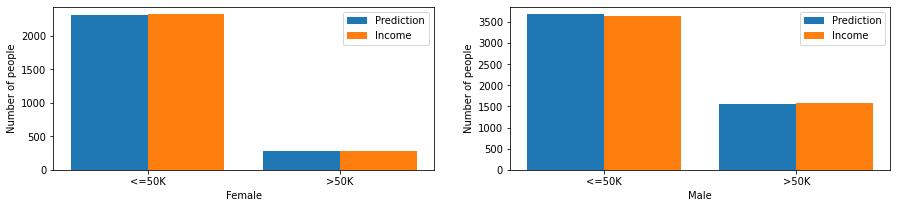

In [54]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'},"gender":{1:"Female",0:"Male"}})
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
for axes in [ax,ax2]:
    if axes == ax:
        sex="Female"
    else: 
        sex="Male"
    axes.bar(X_axis - 0.2, df2[df2['gender']==sex].groupby('gender')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    axes.bar(X_axis + 0.2, df2[df2['gender']==sex].groupby('gender')['income'].value_counts(), 0.4, label = 'Income')
    axes.set_xticks(X_axis,df2['Prediction'].unique())
    axes.set_xlabel(sex)
    axes.set_ylabel("Number of people")
    axes.legend()

The model does not seem to biased based on the gender feature, as their is no real big difference in the predictions and the labels per class. Therefore, there is not real tendency to predict more false positives per class, which means no bias in that direction.

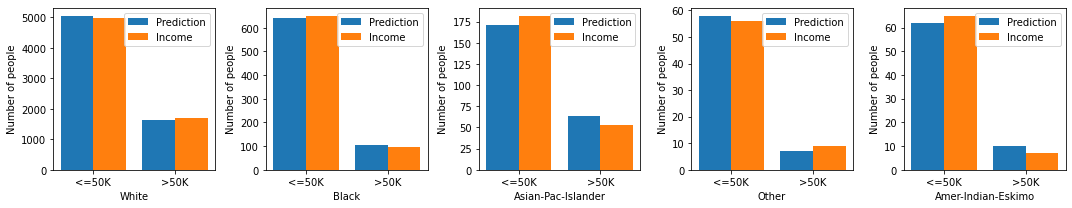

In [55]:
fig, axes = plt.subplots(1,5 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
race_list = df2['race'].unique().tolist()
count = 0
for ax in axes:
    race = race_list[count]
    ax.bar(X_axis - 0.2, df2[df2['race']==race].groupby('race')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    ax.bar(X_axis + 0.2, df2[df2['race']==race].groupby('race')['income'].value_counts(), 0.4, label = 'Income')
    ax.set_xticks(X_axis,df2['Prediction'].unique())
    ax.set_xlabel(race)
    ax.set_ylabel("Number of people")
    ax.legend()
    count += 1
fig.tight_layout()

In [56]:
df_comparison.groupby('race')['income','Prediction'].value_counts()

race                income  Prediction
Amer-Indian-Eskimo  0       0               60
                            1                5
                    1       1                5
                            0                2
Asian-Pac-Islander  0       0              152
                    1       1               34
                    0       1               30
                    1       0               19
Black               0       0              606
                    1       1               61
                    0       1               45
                    1       0               35
Other               0       0               54
                    1       1                5
                            0                4
                    0       1                2
White               0       0             4412
                    1       1             1064
                            0              641
                    0       1              579
dtype: int64

On the contrary, for the race feature, there seems to be some bias involved. We can clearly see that for Amer-Indian-Eskimo, Asian-Pac-Islander and Black persons the model is more likely to predict a higher income although that is not the case, while for Other and White people, it is more likely to predict less income. This shows that there is some small bias against those two groups. Unfortunately, we do not know, which people fall under the Other category. However, we see that the sample is not really big for most groups. So, these deviations could be by chance as well and if we would have more samples, it would balance out (law of large numbers) .

# V. Reiterate and discard race feature

In the following section, we discard the race feature and train the same setting again to have a look if this bias was introduced due to the feature or not. We gonna check if the distributions above are still the same if we train the model without the feature.

In [82]:
df_preprocessed = df.drop(columns=['race'])
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df_preprocessed,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship",'native-country'])

In [83]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [84]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [85]:
#use the defined functions for training the model
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8260
The F1-Score on the validation set: 0.7597
Confusion Matrix : 
[[5280  665]
 [ 695 1175]]


Comparing to the results above, we already see that there is an improvement. But we need to be careful, because we do not use CV. So, this could be due to randomness as well.

In [86]:
#use the defined functions for revert the ohe 
df_comparison = revert_ohe(data_val)

In [87]:
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_val.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

To plot the distribution for the race feature, we join the original table based on the index.

In [88]:
df_comparison = pd.merge(df_comparison, df['race'], left_index=True, right_index=True)

In [89]:
df_comparison.head(5)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,income,Prediction,race
2190,33,10,0,0,0,60,Private,Some-college,Separated,Craft-repair,Own-child,United-States,0,0,White
37436,36,12,0,0,1669,45,Private,Assoc-acdm,Never-married,Prof-specialty,Not-in-family,United-States,0,0,White
18121,23,10,0,0,0,44,Private,Some-college,Never-married,Craft-repair,Not-in-family,United-States,0,0,White
5554,29,10,1,0,0,40,Private,Some-college,Never-married,Adm-clerical,Not-in-family,Guatemala,0,0,White
14601,24,13,0,0,0,20,Local-gov,Bachelors,Never-married,Transport-moving,Own-child,United-States,0,0,White


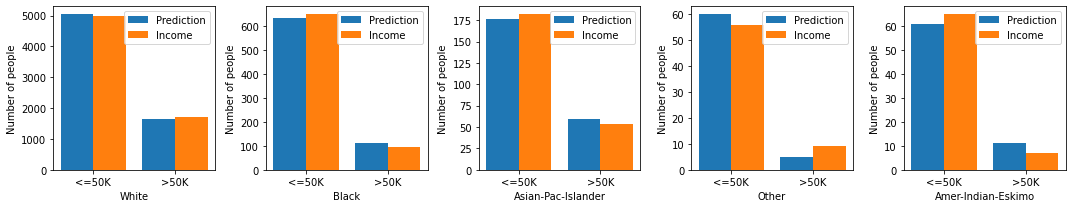

In [90]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'}})
fig, axes = plt.subplots(1,5 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
race_list = df2['race'].unique().tolist()
count = 0
for ax in axes:
    race = race_list[count]
    ax.bar(X_axis - 0.2, df2[df2['race']==race].groupby('race')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    ax.bar(X_axis + 0.2, df2[df2['race']==race].groupby('race')['income'].value_counts(), 0.4, label = 'Income')
    ax.set_xticks(X_axis,df2['Prediction'].unique())
    ax.set_xlabel(race)
    ax.set_ylabel("Number of people")
    ax.legend()
    count += 1
fig.tight_layout()

In [91]:
df_comparison.groupby('race')['income','Prediction'].value_counts()

race                income  Prediction
Amer-Indian-Eskimo  0       0               60
                    1       1                6
                    0       1                5
                    1       0                1
Asian-Pac-Islander  0       0              155
                    1       1               32
                    0       1               27
                    1       0               21
Black               0       0              602
                    1       1               65
                    0       1               49
                    1       0               31
Other               0       0               56
                    1       1                5
                            0                4
White               0       0             4407
                    1       1             1067
                            0              638
                    0       1              584
dtype: int64

After discarding the feature, we get less false negatives (less income predicted, although it is high) for White (641 to 638), and Black (35 to 31) people, while the other results stay the same. However, as the amount of data is that small for some groups, we cannot really distinguish that this happens by chance or if there is bias inside the model. But it seems that discarding the race feature benefits the model performance overall and since it is a highly critical feature, it seems appropriate to do that.

# VI. Biased Train-Test split

In the following part of the notebook, we show another way how bias could be introduced when we are not careful. We split the whole dataset again, but this time not based on a stratified split. We manipulate our split such that most of the cases where women have low income are in the training set and high income women are in the test set. We discard the gender feature and show that even without the feature, it might happen that the algorithm is prone to bias based on the training split.

We begin by creating the preprocessed dataset and split up the set in train and test. However, this time we manipulate the dataset by filtering out the women with high income first (around 1,800 entries/4% of whole set), put them into the test set and then create the remaining split of 16% for the test data. This leads to a split of 80% train and 20% test data. We are not creating a validation set, since we are not gonna optimize anything based on this split

In [70]:
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","native-country","race"])

In [71]:
df_preprocessed[(df_preprocessed['gender']==1)&(df_preprocessed['income']==1)]

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
45,28,11,1,0,0,36,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
89,41,14,1,7688,0,10,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
92,33,14,1,5178,0,10,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
119,43,13,1,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
126,48,16,1,0,0,40,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,13,1,0,0,55,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
48817,34,13,1,0,0,55,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
48819,38,13,1,15020,0,45,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
48826,39,12,1,0,0,20,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [72]:
df_woman_high = df_preprocessed[(df_preprocessed['gender']==1)&(df_preprocessed['income']==1)]

In [73]:
df_preprocessed_bias = df_preprocessed[~((df_preprocessed['gender']==1)&(df_preprocessed['income']==1))]

In [74]:
# first split up in train and test
data_train, data_test, target_train, target_test = train_test_split(df_preprocessed_bias.drop(columns=['income']), df_preprocessed_bias['income'], test_size=0.16, random_state=42, stratify=df_preprocessed_bias['income'])

In [75]:
data_test = pd.concat([data_test, df_woman_high.drop(columns=['income'])])
target_test = pd.concat([target_test, df_woman_high['income']])

We again train a scaler for the numeric features, but we drop the gender column in train and test first.

In [76]:
data_train.drop(columns=['gender'],inplace=True)
data_test.drop(columns=['gender'],inplace=True)

In [77]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [78]:
#use the defined functions for training the model
dt,prediction = model_training(data_train, target_train, data_test, target_test, DecisionTreeClassifier())

The Accuracy on the validation set: 0.7251
The F1-Score on the validation set: 0.6567
Confusion Matrix : 
[[5447  498]
 [2059 1297]]


In [79]:
#use the defined functions for revert the ohe 
df_comparison = revert_ohe(data_test)
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_test.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

Since we discarded the gender feature, we join it again from the original table based on the index.

In [80]:
df_comparison = pd.merge(df_comparison, df['gender'], left_index=True, right_index=True)

In [81]:
df_comparison.head(5)

,age,training-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,race,income,Prediction,gender
13182,21,6,0,0,40,Private,10th,Never-married,Craft-repair,Own-child,United-States,White,0,0,Male
35159,42,9,0,0,40,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,United-States,White,1,0,Male
32068,41,9,0,1887,45,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,United-States,White,1,1,Male
21305,45,9,0,1672,40,Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,United-States,White,0,1,Male
47885,52,9,0,0,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,United-States,White,1,0,Male


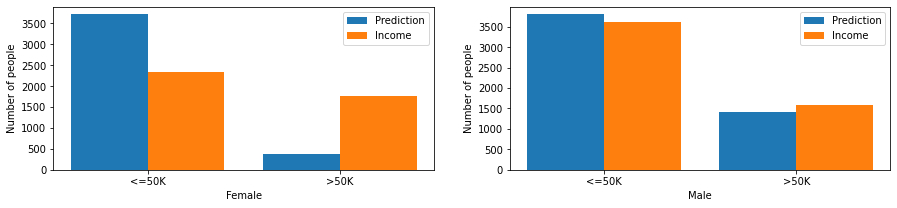

In [82]:
#compare amount of predictions and income
# rename labels into interpretable text
df2 = df_comparison.replace({"Prediction": { 1:'>50K', 0:'<=50K'}, "income": { 1:'>50K', 0:'<=50K'}})
fig, (ax, ax2) = plt.subplots(1,2 ,  figsize=(15,3))

#plot for gender
X_axis = np.arange(len(df2['Prediction'].unique()))
for axes in [ax,ax2]:
    if axes == ax:
        sex="Female"
    else: 
        sex="Male"
    axes.bar(X_axis - 0.2, df2[df2['gender']==sex].groupby('gender')['Prediction'].value_counts(), 0.4, label = 'Prediction')
    axes.bar(X_axis + 0.2, df2[df2['gender']==sex].groupby('gender')['income'].value_counts(), 0.4, label = 'Income')
    axes.set_xticks(X_axis,df2['Prediction'].unique())
    axes.set_xlabel(sex)
    axes.set_ylabel("Number of people")
    axes.legend()



In comparison, to our earlier results for gender, we can clearly see that we have a lot of more false negatives for women such that we predict the lower income class instead of the higher income class. This happens, because we excluded all high income women from the training set. Therefore, the model could not learn that women can have a high income. This shows that bias cannot only be introduced by features itself, but by a biased train-test split as well.

# VII. Model improvement

Unfortunately, we can not give a final answer about the question if bias is introduced or not based on the features itself, although there are signs that it is better to discard the race feature. However, how bias can be introduced by a bad train-test-split is quite obvious and has to be taken into account. In the remaining work, we focus on improving the model by different feature selection methods and hyperparameter optimization. Thereby, we first try three other models, namely Logistic Regression, XGBoost and Random Forest to compare the results to our decision tree and see if they are already better. As baselines, we gonna implement a random rate classifier that uses prior knowledge of class assignments in predicting the class and the prior used decision tree.

In [49]:
df_preprocessed = df.drop(columns=['race'])
#use the defined functions for preprocessing
df_preprocessed = preprocessing(df_preprocessed,{"gender": {'Female': 1, 'Male': 0}, "income": {'>50K': 1, '<=50K': 0}}, ["workclass", "education","marital-status","occupation","relationship","native-country"])

In [50]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['income']), df_preprocessed['income'], test_size=0.2, random_state=42, stratify=df_preprocessed['income'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [51]:
# define standard scaler as above
scaler = StandardScaler()
# features to scale
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

### Baseline

In [108]:
# random rate classifier
# first get the probabilities of each class
prop_high_income = round(len(target_val[target_val==1])/len(target_val),3)
prop_low_income = round(len(target_val[target_val==0])/len(target_val),3)
print(f'Predicting higher income happens in {prop_high_income*100} % of cases')
print(f'Predicting lower income happens in {prop_low_income*100} % of cases')

Predicting higher income happens in 23.9 % of cases
Predicting lower income happens in 76.1 % of cases


In [109]:
#Create prediction vector
pred = np.random.choice([0, 1], size=len(target_val), p=[prop_low_income, prop_high_income])
acc = accuracy_score(target_val,pred) 
f1= f1_score(target_val,pred, average = 'macro') 
print("The Accuracy on the validation set: {:.4f}".format(acc))
print("The F1-Score on the validation set: {:.4f}".format(f1))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,pred)))

The Accuracy on the validation set: 0.6292
The F1-Score on the validation set: 0.4955
Confusion Matrix : 
[[4470 1475]
 [1423  447]]


In [110]:
#check the results for the decision tree
dt,prediction = model_training(data_train, target_train, data_val, target_val, DecisionTreeClassifier())

The Accuracy on the validation set: 0.8261
The F1-Score on the validation set: 0.7592
Confusion Matrix : 
[[5288  657]
 [ 702 1168]]


### More sophisticated Models

In [111]:
#check the results for logistic regression
dt,prediction = model_training(data_train, target_train, data_val, target_val, LogisticRegression())

The Accuracy on the validation set: 0.8535
The F1-Score on the validation set: 0.7847
Confusion Matrix : 
[[5544  401]
 [ 744 1126]]


In [112]:
#check the results for random forest
dt,prediction = model_training(data_train, target_train, data_val, target_val, RandomForestClassifier())

The Accuracy on the validation set: 0.8477
The F1-Score on the validation set: 0.7824
Confusion Matrix : 
[[5453  492]
 [ 698 1172]]


In [113]:
#check the results for xgboost
dt,prediction = model_training(data_train, target_train, data_val, target_val, XGBClassifier(eval_metric='error'))

The Accuracy on the validation set: 0.8760
The F1-Score on the validation set: 0.8200
Confusion Matrix : 
[[5602  343]
 [ 626 1244]]


We see that XGBoost has far better performances than the simple decision tree, logistic regression and random forest. Thus, we gonna focus on XGBoost for further optimization.

### Optimization XGBoost

#### F-Test

We gonna try two different feature selection methods to see if reducing the amount of features might benefit model performance. In a first step, we perform a f-test for calculating the feature importance and if the features are significant for the performance.

In [114]:
# run the F-Test
f, pval = f_classif(data_train, target_train)

# prepare a dataframe to inspect the results
stat = pd.DataFrame({ 'feature': data_train.columns, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)

# show the results
display(stat)

,feature,F value,p value
0,age,1725.197091,0.00
1,training-num,3894.319306,0.00
2,gender,1507.788825,0.00
3,capital-gain,1606.728813,0.00
4,capital-loss,755.327196,0.00
...,...,...,...
97,native-country_Thailand,0.274817,0.60
98,native-country_Trinadad&Tobago,5.350344,0.02
99,native-country_United-States,34.716022,0.00
100,native-country_Vietnam,5.945293,0.01


We create a list of all the features that have a p value of 0.05 or higher, because they are not significant. We discard them and retrain the model to see if we achieve an improvement.

In [115]:
unsignificant = stat[stat['p value']>=0.05]['feature'].to_list()

In [116]:
data_train2 = data_train.drop(columns=unsignificant)
data_val2 = data_val.drop(columns=unsignificant)

In [117]:
#check the results for xgboost reduction via f-test
dt,prediction = model_training(data_train2, target_train, data_val2, target_val, XGBClassifier(eval_metric='error'))

The Accuracy on the validation set: 0.8731
The F1-Score on the validation set: 0.8161
Confusion Matrix : 
[[5586  359]
 [ 633 1237]]


Unfortunately, it seems that this easy method did not improve our model. Therefore, we gonna try a more sophisticated feature selection method by using a backward selection within a cross valdidation.

#### Cross-Validation with Backward Selection

In a next step, use the backward selection with cross validation to filter out features beginning with the whole set.

In [118]:
cv_stratified = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)

In [119]:
xgb = XGBClassifier(eval_metric='error')
rfecv = RFECV(xgb, step=1, cv=cv_stratified,scoring='f1_macro', verbose=2)
rfecv.fit(data_train, target_train)

Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 fe

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 fe

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 feature

Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 fe

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              eval_metric='error', gamma=None, gpu_id=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
               

In [120]:
print("Optimum number of features: %d" % rfecv.n_features_)

Optimum number of features: 67


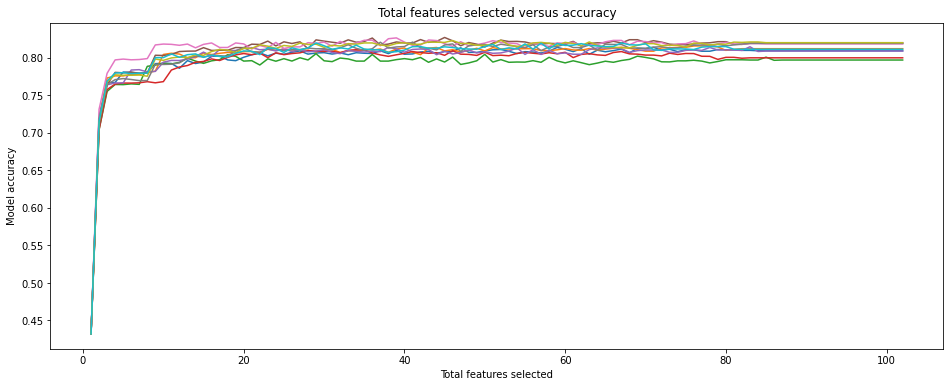

In [121]:
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [122]:
selected_features = rfecv.get_support(1)
print(selected_features)

[  0   1   2   3   4   5   6   7   8  10  11  12  13  16  17  19  20  22
  23  24  26  27  29  30  31  32  33  34  35  36  37  39  41  42  43  44
  45  47  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64
  69  71  73  80  81  84  86  90  93  95  98  99 101]


In [52]:
selected_features = [ 0 ,  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  16,  17,  19,  20,  22,
  23,  24,  26,  27,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  41,  42,  43,  44,
  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,
  69,  71,  73,  80,  81,  84,  86,  90,  93,  95,  98,  99, 101]

In [53]:
#selected_features = rfecv.get_support(1)
data_train = data_train[data_train.columns[selected_features]]
data_val = data_val[data_val.columns[selected_features]]
data_test = data_test[data_test.columns[selected_features]]

We see that the optimal number of features is 67 and that the algorithm reaches a saturation level. We filter down our sets on the recommended 67 features and look at the results.

In [54]:
#check the results for xgboost backward feature selection
dt,prediction = model_training(data_train, target_train, data_val, target_val, XGBClassifier(eval_metric='error'))

The Accuracy on the validation set: 0.8765
The F1-Score on the validation set: 0.8215
Confusion Matrix : 
[[5595  350]
 [ 615 1255]]


Our results improved compared to our previous best outcomes from accuracy = 0.8760 and f1_score = 0.8200 to accuracy = 0.8765 and f1_score = 0.8215. We cannot be 100% sure that that might a sustainable improvement or if its random variation. However, since we have approximately the same performance with 35% less features, we prefer the new feature selection (Occam's Razor).

### Hyperparameter Tuning

In a last improvement step, we optimize our hyperparameters. Since the search space of possible solutions is too big for a brute force search, we use a two step approach. First, we utilize bayesian search for finding a good solution by optimizing a surrogate. Afterwards, we use the best parameters of the bayesian search or the default settings to try to improve the model locally in that area via a grid search.

In [125]:
bayes_grid = { # 75 fits of 5 fold cv, takes around 1 1/2 hours
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "min_child_weight": Integer(0, 10),
    "max_depth": Integer(1, 50),
    "max_delta_step": Integer(0, 10),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "log-uniform"),
    "colsample_bylevel": Real(0.01, 1.0, "log-uniform"),
    "reg_lambda": Real(1e-9, 1000, "log-uniform"),
    "reg_alpha": Real(1e-9, 1.0, "log-uniform"),
    "gamma": Real(1e-9, 0.5, "log-uniform"),
    "min_child_weight": Integer(0, 5),
    "n_estimators": Integer(5, 500),
}
xgb = XGBClassifier(eval_metric='error')
#define a stratified cross validation
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
xgb_bayes = BayesSearchCV(xgb,search_spaces=bayes_grid, cv=cv_stratified, scoring ='f1_macro', refit = True,n_iter=75, random_state = 42,verbose=2)
xgb_bayes.fit(data_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   5.3s
[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   5.3s
[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.0593607063

[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   4.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=  14.6s
[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464

[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   1.4s
[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=1000.0, subsample=1.0; total time= 1.0min
[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamm

[CV] END colsample_bylevel=0.2785973550322379, colsample_bytree=0.08484464337192284, gamma=1e-09, learning_rate=0.04548086224105032, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=400, reg_alpha=1e-09, reg_lambda=1000.0, subsample=0.6440189879951507; total time=   4.6s
[CV] END colsample_bylevel=0.2785973550322379, colsample_bytree=0.08484464337192284, gamma=1e-09, learning_rate=0.04548086224105032, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=400, reg_alpha=1e-09, reg_lambda=1000.0, subsample=0.6440189879951507; total time=   4.6s
[CV] END colsample_bylevel=0.2785973550322379, colsample_bytree=0.08484464337192284, gamma=1e-09, learning_rate=0.04548086224105032, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=400, reg_alpha=1e-09, reg_lambda=1000.0, subsample=0.6440189879951507; total time=   4.6s
[CV] END colsample_bylevel=0.2785973550322379, colsample_bytree=0.08484464337192284, gamma=1e-09, learning_rate=0.04548086224105032, 

[CV] END colsample_bylevel=1.0, colsample_bytree=0.07667788323250989, gamma=0.000855984119157048, learning_rate=0.8034551477830688, max_delta_step=8, max_depth=23, min_child_weight=2, n_estimators=50, reg_alpha=2.6726775928135054e-08, reg_lambda=224.31952590703915, subsample=0.09107172332043588; total time=   0.5s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.07667788323250989, gamma=0.000855984119157048, learning_rate=0.8034551477830688, max_delta_step=8, max_depth=23, min_child_weight=2, n_estimators=50, reg_alpha=2.6726775928135054e-08, reg_lambda=224.31952590703915, subsample=0.09107172332043588; total time=   0.6s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.07667788323250989, gamma=0.000855984119157048, learning_rate=0.8034551477830688, max_delta_step=8, max_depth=23, min_child_weight=2, n_estimators=50, reg_alpha=2.6726775928135054e-08, reg_lambda=224.31952590703915, subsample=0.09107172332043588; total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 

[CV] END colsample_bylevel=0.11089794249828201, colsample_bytree=0.10849130966839833, gamma=0.04401938175814953, learning_rate=1.0, max_delta_step=2, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=2.573110505563528e-08, reg_lambda=0.001552361594290632, subsample=0.7408465389290919; total time=   6.3s
[CV] END colsample_bylevel=0.11089794249828201, colsample_bytree=0.10849130966839833, gamma=0.04401938175814953, learning_rate=1.0, max_delta_step=2, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=2.573110505563528e-08, reg_lambda=0.001552361594290632, subsample=0.7408465389290919; total time=   6.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.10444757251692395, colsample_bytree=0.0962663794150312, gamma=0.12870479757534006, learning_rate=0.21760003988266768, max_delta_step=5, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=0.3180658822751873, reg_lambda=4.58098157111617e-09, subsample=0.5852469561972665

[CV] END colsample_bylevel=0.14829985193380493, colsample_bytree=0.5182992496604915, gamma=3.844561639074477e-06, learning_rate=0.027922938314627905, max_delta_step=10, max_depth=19, min_child_weight=2, n_estimators=500, reg_alpha=0.00022507553985555762, reg_lambda=0.007069756714818584, subsample=0.5440591360974508; total time=  27.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.28648244943778445, colsample_bytree=0.08727556696439354, gamma=0.00020513592996544092, learning_rate=0.39951065752927256, max_delta_step=10, max_depth=22, min_child_weight=2, n_estimators=337, reg_alpha=4.5535864899521004e-05, reg_lambda=1000.0, subsample=0.9486626695568322; total time=   4.0s
[CV] END colsample_bylevel=0.28648244943778445, colsample_bytree=0.08727556696439354, gamma=0.00020513592996544092, learning_rate=0.39951065752927256, max_delta_step=10, max_depth=22, min_child_weight=2, n_estimators=337, reg_alpha=4.5535864899521004e-05, reg_lambda=1000.0, subsa

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.5690121129021709, colsample_bytree=0.7889526306926968, gamma=2.9314917580657545e-06, learning_rate=0.024223631884345398, max_delta_step=8, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0.001468214211444276, reg_lambda=3.2674306775447106e-05, subsample=0.5279228646144373; total time=  14.0s
[CV] END colsample_bylevel=0.5690121129021709, colsample_bytree=0.7889526306926968, gamma=2.9314917580657545e-06, learning_rate=0.024223631884345398, max_delta_step=8, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0.001468214211444276, reg_lambda=3.2674306775447106e-05, subsample=0.5279228646144373; total time=  17.2s
[CV] END colsample_bylevel=0.5690121129021709, colsample_bytree=0.7889526306926968, gamma=2.9314917580657545e-06, learning_rate=0.024223631884345398, max_delta_step=8, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0.001468214211444276, reg_lambda=3.2674306

[CV] END colsample_bylevel=1.0, colsample_bytree=0.3251151986978744, gamma=1e-09, learning_rate=0.01, max_delta_step=2, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=0.03180561002309462, subsample=0.01; total time=   0.1s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.3251151986978744, gamma=1e-09, learning_rate=0.01, max_delta_step=2, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=0.03180561002309462, subsample=0.01; total time=   0.1s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.3251151986978744, gamma=1e-09, learning_rate=0.01, max_delta_step=2, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=0.03180561002309462, subsample=0.01; total time=   0.1s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.3251151986978744, gamma=1e-09, learning_rate=0.01, max_delta_step=2, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=0.03180561002309462, subsample=0.01; total t

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.44686293146034456, colsample_bytree=0.4852710175782253, gamma=0.49999999999999994, learning_rate=0.07585144439738514, max_delta_step=6, max_depth=20, min_child_weight=0, n_estimators=264, reg_alpha=1.267561730668103e-07, reg_lambda=6.287882895069734e-08, subsample=0.22260920963235123; total time=  18.5s
[CV] END colsample_bylevel=0.44686293146034456, colsample_bytree=0.4852710175782253, gamma=0.49999999999999994, learning_rate=0.07585144439738514, max_delta_step=6, max_depth=20, min_child_weight=0, n_estimators=264, reg_alpha=1.267561730668103e-07, reg_lambda=6.287882895069734e-08, subsample=0.22260920963235123; total time=  19.0s
[CV] END colsample_bylevel=0.44686293146034456, colsample_bytree=0.4852710175782253, gamma=0.49999999999999994, learning_rate=0.07585144439738514, max_delta_step=6, max_depth=20, min_child_weight=0, n_estimators=264, reg_alpha=1.267561730668103e-07, reg_lambda=6.2878828950

[CV] END colsample_bylevel=0.2332223220072433, colsample_bytree=0.65621558857183, gamma=6.80957660035464e-08, learning_rate=0.015844755820747715, max_delta_step=8, max_depth=43, min_child_weight=4, n_estimators=472, reg_alpha=1.2152042387230136e-07, reg_lambda=0.11711095801897622, subsample=0.7324711626843305; total time=  21.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.29113346264041245, colsample_bytree=0.14066637609620977, gamma=0.49999999999999994, learning_rate=0.3204638063753322, max_delta_step=10, max_depth=43, min_child_weight=3, n_estimators=281, reg_alpha=3.1802965566323563e-06, reg_lambda=0.0003023279272614854, subsample=0.21558648774661857; total time=   3.0s
[CV] END colsample_bylevel=0.29113346264041245, colsample_bytree=0.14066637609620977, gamma=0.49999999999999994, learning_rate=0.3204638063753322, max_delta_step=10, max_depth=43, min_child_weight=3, n_estimators=281, reg_alpha=3.1802965566323563e-06, reg_lambda=0.000302327

[CV] END colsample_bylevel=0.13712306629904703, colsample_bytree=0.855180398967242, gamma=1e-09, learning_rate=0.6923238298643144, max_delta_step=10, max_depth=1, min_child_weight=4, n_estimators=56, reg_alpha=3.203341394424593e-05, reg_lambda=6.53786102668518, subsample=0.3245471774387745; total time=   0.6s
[CV] END colsample_bylevel=0.13712306629904703, colsample_bytree=0.855180398967242, gamma=1e-09, learning_rate=0.6923238298643144, max_delta_step=10, max_depth=1, min_child_weight=4, n_estimators=56, reg_alpha=3.203341394424593e-05, reg_lambda=6.53786102668518, subsample=0.3245471774387745; total time=   0.6s
[CV] END colsample_bylevel=0.13712306629904703, colsample_bytree=0.855180398967242, gamma=1e-09, learning_rate=0.6923238298643144, max_delta_step=10, max_depth=1, min_child_weight=4, n_estimators=56, reg_alpha=3.203341394424593e-05, reg_lambda=6.53786102668518, subsample=0.3245471774387745; total time=   0.6s
[CV] END colsample_bylevel=0.13712306629904703, colsample_bytree=0.

[CV] END colsample_bylevel=0.4610086076566963, colsample_bytree=0.44452492623210915, gamma=1e-09, learning_rate=0.6315395690231445, max_delta_step=5, max_depth=1, min_child_weight=3, n_estimators=15, reg_alpha=0.0013137377619636507, reg_lambda=1e-09, subsample=1.0; total time=   0.1s
[CV] END colsample_bylevel=0.4610086076566963, colsample_bytree=0.44452492623210915, gamma=1e-09, learning_rate=0.6315395690231445, max_delta_step=5, max_depth=1, min_child_weight=3, n_estimators=15, reg_alpha=0.0013137377619636507, reg_lambda=1e-09, subsample=1.0; total time=   0.1s
[CV] END colsample_bylevel=0.4610086076566963, colsample_bytree=0.44452492623210915, gamma=1e-09, learning_rate=0.6315395690231445, max_delta_step=5, max_depth=1, min_child_weight=3, n_estimators=15, reg_alpha=0.0013137377619636507, reg_lambda=1e-09, subsample=1.0; total time=   0.1s
[CV] END colsample_bylevel=0.4610086076566963, colsample_bytree=0.44452492623210915, gamma=1e-09, learning_rate=0.6315395690231445, max_delta_ste

[CV] END colsample_bylevel=0.5416500725960512, colsample_bytree=0.27439031593340935, gamma=0.0020244954663995113, learning_rate=0.0714067705292769, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=239, reg_alpha=2.514858034931483e-07, reg_lambda=1e-09, subsample=0.9630723172770822; total time=  11.5s
[CV] END colsample_bylevel=0.5416500725960512, colsample_bytree=0.27439031593340935, gamma=0.0020244954663995113, learning_rate=0.0714067705292769, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=239, reg_alpha=2.514858034931483e-07, reg_lambda=1e-09, subsample=0.9630723172770822; total time=  13.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=0.6523850622650216, colsample_bytree=0.7569127871938385, gamma=2.7165845609611862e-08, learning_rate=0.022063776232491943, max_delta_step=6, max_depth=16, min_child_weight=1, n_estimators=264, reg_alpha=1.0, reg_lambda=0.005343774674720804, subsample=1.0; total time=  25.5s
[CV

[CV] END colsample_bylevel=0.1182504204508359, colsample_bytree=0.175516005489433, gamma=7.22985006260551e-05, learning_rate=0.15436588974181706, max_delta_step=0, max_depth=48, min_child_weight=5, n_estimators=500, reg_alpha=0.4127962776702092, reg_lambda=0.40309630539778857, subsample=1.0; total time=   4.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=4.0708607705278865e-09, learning_rate=1.0, max_delta_step=8, max_depth=1, min_child_weight=0, n_estimators=239, reg_alpha=1.0, reg_lambda=0.0035104941105105537, subsample=0.4591359337398839; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=4.0708607705278865e-09, learning_rate=1.0, max_delta_step=8, max_depth=1, min_child_weight=0, n_estimators=239, reg_alpha=1.0, reg_lambda=0.0035104941105105537, subsample=0.4591359337398839; total time=   2.5s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=4.0708607705278865e-09, le

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False,
                                      eval_metric='error', gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None...
                             'min_child_weight': Integer(low=0, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=500, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=1.0, prior='log-uniform', 

In [126]:
#check the results for bayesian optimization
dt,prediction = model_training(data_train, target_train, data_val, target_val, xgb_bayes.best_estimator_)
print(f'The best model has the following hyperparameter:{xgb_bayes.best_estimator_}')

The Accuracy on the validation set: 0.8742
The F1-Score on the validation set: 0.8163
Confusion Matrix : 
[[5610  335]
 [ 648 1222]]
The best model has the following hyperparameter:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.9389594672770689,
              enable_categorical=False, eval_metric='error', gamma=1e-09,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.02244680952861409, max_delta_step=0, max_depth=11,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.00040855509310934424,
              reg_lambda=1e-09, scale_pos_weight=1,
              subsample=0.7921690232254716, tree_method='exact',
              validate_parameters=1, verbosity=None)


We want to make use of the results of the bayesian optimization to narrow down the search space in our grid. Unfortunately, it seems that the results of the 75 samples we used, did not improve our default settings. So, we investigate the range around the default settings of XGBoost for possible further improvements.

In [63]:
random_grid = { #1440 fits -> takes about (start 10:30 until 11:45)
        'n_estimators': [50,100],
        'gamma': [0,0.1],
        'max_depth': [5,6,7],
        'min_child_weight': [0.5,1],
        'subsample': [0.9,1.0],
        'colsample_bytree': [0.9,1.0],
        'learning_rate': [0.2,0.3,0.4]
        }
xgb = XGBClassifier(eval_metric='error')
#define a stratified cross validation
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
# Random search of parameters, using 5 fold cross validation
xgb_random = GridSearchCV(xgb, random_grid, cv=cv_stratified, scoring ='f1_macro', verbose=2, refit=True)
# Fit the random search model
xgb_random.fit(data_train, target_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_dep

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total tim

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   4.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; to

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.6s

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=50, subsam

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subs

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   4.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   5.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   4.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=0.5, n_estimators=100, s

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=50, subsample=1.0; tota

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=50, subsa

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total tim

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=1.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=100, subsample=0.9; total time=  

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=5, min_child_weight=0.5, n_estimators=100, subsample=0.9; to

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=6, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   1.8s

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=0.5, n_estimators=50, subsampl

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, subs

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   6.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   4.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, subsample=0.9; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=0.5, n_estimators=100, s

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=50, subsample=1.0; tota

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=6, min_child_weight=0.5, n_estimators=50, subsa

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=0.5, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.4, max_depth=7, min_child_weight=1, n_estimators=50, subsamp

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_gri

In [64]:
#check the results for the grid search optimization
dt,prediction = model_training(data_train, target_train, data_val, target_val, xgb_random.best_estimator_)
print(f'The best model has the following hyperparameter:{xgb_random.best_estimator_}')

The Accuracy on the validation set: 0.8755
The F1-Score on the validation set: 0.8184
Confusion Matrix : 
[[5612  333]
 [ 640 1230]]
The best model has the following hyperparameter:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [55]:
random_grid = { #320 fits -> takes about 20-30 minutes
        'n_estimators': [100,150],
        'gamma': [0],
        'max_depth': [4,5],
        'min_child_weight': [1,2],
        'subsample': [1.0],
        'colsample_bytree': [0.8, 0.9],
        'learning_rate': [0.3],
        'colsample_bylevel':[0.9,1.0],
        'colsample_bynode':[0.9,1.0]
        }
xgb = XGBClassifier(eval_metric='error')
#define a stratified cross validation
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
# Random search of parameters, using 5 fold cross validation
xgb_random = GridSearchCV(xgb, random_grid, cv=cv_stratified, scoring ='f1_macro', verbose=2, refit=True)
# Fit the random search model
xgb_random.fit(data_train, target_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.3s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time= 

[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   3.1s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, c

[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, c

[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   3.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   2.9s
[CV] END colsample_bylevel=0.9, colsample_bynode=1.0, c

[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   2.7s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   2.8s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   2.7s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=150, subsample=1.0; total time=   2.9s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, c

[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=0.9, c

[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   3.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   3.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   3.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   4.0s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, c

[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   4.3s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=150, subsample=1.0; total time=   3.9s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   2.6s
[CV] END colsample_bylevel=1.0, colsample_bynode=1.0, c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_grid={'colsample_bylevel': [0.9, 1.0],
                         'colsample_

In [56]:
#check the results for the grid search optimization
dt,prediction = model_training(data_train, target_train, data_val, target_val, xgb_random.best_estimator_)
print(f'The best model has the following hyperparameter:{xgb_random.best_estimator_}')

The Accuracy on the validation set: 0.8773
The F1-Score on the validation set: 0.8222
Confusion Matrix : 
[[5603  342]
 [ 617 1253]]
The best model has the following hyperparameter:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1.0, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)


After two iterations of refinement for our grid, results show an improvement of 0.07 percentage points from 0.8765 to 0.8773 in accuracy and 0.8215 to 0.8222 in the f1-score. With further parameter refinements it should be possible to increase this improvement.

# VII. Test Set and Mistake Analysis

We gonna use the results of our hyperparameter optimization with train+val as training data and evaluate how good the model generalizes on the test set and dive into the failures of our model and understand what is happening.

In [57]:
train_val = pd.concat([data_train, data_val], axis=0)
train_val_target = pd.concat([target_train, target_val], axis=0)

In [59]:
xgb_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1.0, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [60]:
#check final results on test set
dt,prediction = model_training(train_val, train_val_target, data_test, target_test, xgb_best,test =True)

The Accuracy on the test set: 0.8790
The F1-Score on the test set: 0.8238
Confusion Matrix : 
[[7027  404]
 [ 778 1560]]


We can see a good generalization, as we have nearly the same results as on the validation set. Therefore, we can conclude that approach is able to handle unknown data really well with an accuracy of 0.8790 and an f1_score of 0.8238. In the next step, we investigate the feature importance of the final model to see which features have the highest influence and if that is explainable in reality.

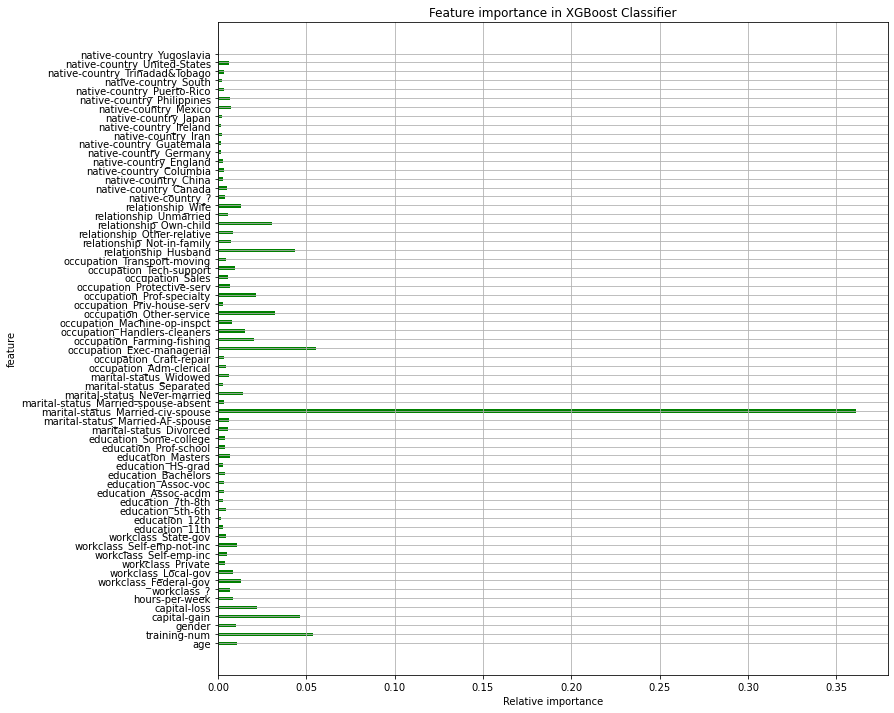

<Figure size 864x864 with 0 Axes>

In [62]:
#modelname.feature_importance_
y = dt.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(train_val, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(12,12))
fig.set_size_inches(12, 12, forward=True)

The most important feature by far, outshining all other features, is the marital status with the value Married-civ-spouse that has the most influence on the model. The value corresponds to a person that is married and their partner is not part of the US armed forces in any way. Unfortunately, as we can see below it does not seem that there is a clear tendency towards one of the income classes for this feature and it is not directly clear why its influence is that high. Other more important features are better explainable, e.g., the amount of training years: the more training years one has the more probable is a high income. It is also explainable why capital gain and capital loss have a high influence, because if you have an higher income, it is more likely that you invest money, as you do not necessary need all money for living expenses. This leads to capital gains or losses over time. One top of this being an executive as occupation does have a high impact as well, which makes sense, because most often managers earn more than "normal" employees.

In [63]:
print(f'People married to a civil partner: {len(df[(df["marital-status"]=="Married-civ-spouse")])}')
print(f'People of that group with high income: {len(df[(df["marital-status"]=="Married-civ-spouse")&(df["income"]==">50K")])}')
print(f'People of that group with low income: {len(df[(df["marital-status"]=="Married-civ-spouse")&(df["income"]!=">50K")])}')

People married to a civil partner: 22379
People of that group with high income: 9984
People of that group with low income: 12395


In a last step, we investigate if we can see a tendency in the false negative and false positive predictions that could explain why the model has problems in classifying them. We revert our preprocessing steps again to see if we can recognize tendencies in the original features and look at the distribution of our false negatives and false positives and compare them to their counterparts in the original dataset. We only compare the distributions of the numerical features due to simplicity reasons. It has to be noted that we have changed the naming of educational-num to training-num in the course of this work.

In [64]:
#use the defined functions for revert the ohe 
df_comparison = revert_ohe(data_test)
# concate test set, target and final prediction for further use
df_comparison = pd.concat([df_comparison.reset_index(), target_test.reset_index(drop=True),pd.Series(prediction),], axis=1).set_index('index')
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )
# on top of that we inverse transform the numerical columns and change them to integer again
numerical_features = ['age','training-num', 'capital-gain','capital-loss','hours-per-week' ]
df_comparison[numerical_features] = scaler.inverse_transform(df_comparison[numerical_features])
df_comparison[numerical_features] = df_comparison[numerical_features].astype(int)

In [65]:
#create a dataframe containing only wrong predictions
df_wrong_predictions = df_comparison[(df_comparison.income!=df_comparison.Prediction)]

We start with the comparison of the distribution for high income persons to those that have been misclassified as high income (false positives).

In [66]:
df[df['income']=='>50K'].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,11687.00,44.28,10.56,19.00,36.00,43.00,51.00,90.00
educational-num,11687.00,11.60,2.38,1.00,10.00,12.00,13.00,16.00
capital-gain,11687.00,4042.24,14756.77,0.00,0.00,0.00,0.00,99999.00
capital-loss,11687.00,193.53,593.21,0.00,0.00,0.00,0.00,3683.00
hours-per-week,11687.00,45.45,11.09,1.00,40.00,40.00,50.00,99.00


In [67]:
df_wrong_predictions[df_wrong_predictions['income']==1][['age','training-num','capital-gain','capital-loss','hours-per-week']].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,778.00,42.67,11.55,22.00,34.00,41.00,50.00,81.00
training-num,778.00,10.07,2.22,2.00,9.00,10.00,11.00,16.00
capital-gain,778.00,9.55,266.38,0.00,0.00,0.00,0.00,7430.00
capital-loss,778.00,19.88,191.66,0.00,0.00,0.00,0.00,2377.00
hours-per-week,778.00,43.99,11.00,2.00,40.00,40.00,50.00,99.00


We can see that there are some small differences in the distributions for age that seem rather marginal around the age of 40. However, we can see differences of more than one educational-year lower in the overall mean which might explain, why the algorithm classifies these examples as low income, since lower educational-years are an indicator for lower income. On top of that, we see that those false negatives (high income - low prediction) have overall nearly no capital-gains or capital-losses. This can also be a reason why they are classified as low income, because high values are an indicator for higher income and wealth, e.g., due to invested capital.

In [68]:
df[df['income']=='<=50K'].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,37155.00,36.87,14.10,17.00,25.00,34.00,46.00,90.00
educational-num,37155.00,9.60,2.44,1.00,9.00,9.00,10.00,16.00
capital-gain,37155.00,147.01,936.75,0.00,0.00,0.00,0.00,41310.00
capital-loss,37155.00,54.15,313.32,0.00,0.00,0.00,0.00,4356.00
hours-per-week,37155.00,38.84,12.36,1.00,35.00,40.00,40.00,99.00


In [69]:
df_wrong_predictions[df_wrong_predictions['income']==0][['age','training-num','capital-gain','capital-loss','hours-per-week']].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
age,404.00,43.93,10.12,24.00,36.00,43.00,51.00,88.00
training-num,404.00,11.83,2.06,3.00,10.00,13.00,13.00,16.00
capital-gain,404.00,122.06,789.30,0.00,0.00,0.00,0.00,6767.00
capital-loss,404.00,46.63,296.81,0.00,0.00,0.00,0.00,2258.00
hours-per-week,404.00,46.49,11.69,2.00,40.00,43.00,50.00,99.00


We also compare the distributions for lower income to those that have been misclassified as higher income, although they have lower income and see if we can spot differences that might explain why it is classified as high income. In this case, we detect that the mean of educational-years are more than two years higher than the one for lower income and even higher than the mean of people with higher income as seen above. In addition, there is a difference of approximately 8 years in the mean of hours-per-week and age, which is again a strong indicatior and possible explanation, why these examples are classified wrongly as high income. The differences in capital-gain and -loss are rather marginal again. 

As a conclusion for this part this part, we will look into different rows that have been classified wrong for the specific target to see if something anomal stands out directly.

In [70]:
df_wrong_predictions[df_wrong_predictions['income']==0].head(15)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,income,Prediction
index,,,,,,,,,,,,,,
524,53,10,0,0,0,50,Local-gov,Some-college,Married-civ-spouse,Exec-managerial,Husband,United-States,0,1
38546,42,16,0,0,0,40,Private,11th,Married-civ-spouse,Prof-specialty,Husband,?,0,1
40209,50,12,0,0,0,45,Private,Assoc-acdm,Married-civ-spouse,Craft-repair,Husband,United-States,0,1
21144,41,11,0,0,0,40,State-gov,Assoc-voc,Married-civ-spouse,Exec-managerial,Husband,United-States,0,1
31262,32,13,0,0,0,44,Private,Bachelors,Married-civ-spouse,Sales,Husband,United-States,0,1
34560,72,9,1,0,0,50,Private,HS-grad,Married-civ-spouse,Exec-managerial,Wife,England,0,1
36933,32,9,0,0,0,40,Federal-gov,HS-grad,Married-civ-spouse,Tech-support,Husband,United-States,0,1
26388,31,13,0,0,0,60,Private,Bachelors,Married-civ-spouse,Adm-clerical,Husband,?,0,1
34231,57,9,0,0,0,40,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,United-States,0,1


For the false positive sample, we can see no direct extreme, interesting behaviour outside the fact the number of educational years seems to be higher on average, which might explain the high prediction and furthermore, that we have a lot of persons in executive roles (occupation feature), which typically earn more money. Otherwise, the features are more of an indicator for lower income class like capital-gains and losses.

In [71]:
df_wrong_predictions[df_wrong_predictions['income']==1].head(15)

,age,training-num,gender,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,native-country,income,Prediction
index,,,,,,,,,,,,,,
11488,38,9,0,0,0,40,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,United-States,1,0
45549,26,10,0,0,0,55,Local-gov,Some-college,Married-civ-spouse,Protective-serv,Husband,United-States,1,0
34382,43,9,0,0,0,40,Private,HS-grad,Married-civ-spouse,Other-service,Husband,United-States,1,0
38439,42,9,0,0,0,40,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,United-States,1,0
26572,59,6,0,0,0,40,Private,11th,Married-civ-spouse,Transport-moving,Husband,United-States,1,0
42586,27,13,0,0,0,40,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,?,1,0
35649,50,9,0,0,0,40,Self-emp-not-inc,HS-grad,Married-civ-spouse,Transport-moving,Husband,United-States,1,0
27715,46,9,0,0,0,40,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,United-States,1,0
17642,52,9,0,0,0,40,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,United-States,1,0


What is striking about those examples, is the fact that the number of educational years is in most cases 9 years or lower, which can be an indicator for the lower prediction, because they only graduated from high school. Unfortunately, there is no further outlying behaviour in this sample, expect for the fact that one person only works 9 hours per week, a clear reason for the lower prediction.

## VIII. Summary and Outlook

In the following, we will give a short summary over all the finding and an outlook what could be further possibilites for the processing of the dataset.

Summary:

- Good results overall in classification with best model accuracy = 0.8790 and f1 = 0.8238 on the test set.
- XGBoost outperforms others by minimum two percentage points.
- Bias in features may be present, but hard to verify, because the groups, especially for race, are rather small.
- Bias due to a wrong train-test-split can happen fast and that needs to be handled with care. 
- One feature (marital-status_Married-civ-spouse) is responsible for more than 35% of overall feature importance.
- Distributions of wrongly classified examples vary a lot in means of numerical variables compared to the means of the original target overall.
- Reduction of features from 102 to 67 possible without performance loss.

Outlook:

- Deep dive into the feature importance Married-civ-spouse.
- Explore wrongly classified examples via, e.g., Lime or Local explainability.
- Deep-dive into wrong classifications to come up with features to better distinguish those examples.
- Handling or discarding of remaining '?' in dataset.
- Checking if removing correlated features can improve the results.
- Generate features for possible improvement of models (for example brute force linear combinations of features via featuretools package or brainstorming for possible feature combinations).
- Outlier removal via e.g., standard statistics or algorithms like isolation forest to see if the results improve (e.g., missclassified person with only 9 hous of work).
- Try out further models, for example LightGBM.